In [12]:
import numpy as np
import urllib.request
import scipy.optimize
import random
import matplotlib.pyplot as plt

In [13]:
lam = 1.0

In [14]:
def parseData(fname):
    for l in urllib.request.urlopen(fname):
        yield eval(l)

In [15]:
# load dataset
print ("Loading dataset......")
data = list(parseData("http://jmcauley.ucsd.edu/cse255/data/beer/beer_50000.json"))
print ("done")

Loading dataset......
done


In [16]:
# Shuffle the data and split it into three 
random.shuffle(data)
train_set = data[:int(len(data)/3)]
test_set = data[int(len(data)/3):int(len(data)/3)*2]
validate_set = data[int(len(data)/3)*2:]

In [17]:
# Construct train Input for Q1.1
X_train = [[1, x['review/taste'], x['review/appearance'], x['review/aroma'], x['review/palate'], x['review/overall']] for x in train_set] 
Y_train = [True if x['beer/ABV'] >= 6.5 else False for x in train_set]

In [18]:
# Construct validation Input for Q1.1
X_valid = [[1, x['review/taste'], x['review/appearance'], x['review/aroma'], x['review/palate'], x['review/overall']] for x in validate_set] 
Y_valid = [True if x['beer/ABV'] >= 6.5 else False for x in validate_set]

In [19]:
# Construct test Input for Q1.1
X_test = [[1, x['review/taste'], x['review/appearance'], x['review/aroma'], x['review/palate'], x['review/overall']] for x in test_set] 
Y_test = [True if x['beer/ABV'] >= 6.5 else False for x in test_set]

In [20]:
# Construct Sigmoid Function
def My_sigmoid(x):
    return 1/(1+np.exp(-x))

In [21]:
# Inner Multiply
def inner(x, y):
    return sum(x[i] * y[i] for i in range(len(x)))

In [22]:
# Construct Objective
def f (theta, x, y, lam):
    negative_likelihood = 0
    for i in range(len(x)):
        logits = inner(x[i],theta)
        negative_likelihood = negative_likelihood - np.log(1+np.exp(-logits))
        if not y[i]:
            negative_likelihood = negative_likelihood - logits
    for k  in range(len(theta)):
        negative_likelihood = negative_likelihood - lam * theta[k]*theta[k]
    return -negative_likelihood

In [23]:
# Calculate the Derivative
def fprime(theta, x, y, lam):
    dl = [0] * len(theta)
    # all together there are len(theta) cofficients
    for i in range(len(x)):
        logits = inner(x[i],theta)
        for k in range(len(theta)):
            dl[k] += x[i][k] * (1-My_sigmoid(logits))
            if not y[i]:
                dl[k] -= x[i][k]
    for k in range(len(theta)):
        dl[k] -= lam*2*theta[k]
    return np.array([-x for x in dl])

In [24]:
# Traning process
def train(lam,x,y):
    theta,_,_ = scipy.optimize.fmin_l_bfgs_b(f, [0]*len(x[0]), fprime, pgtol = 10, args = (x, y, lam))
    return theta

In [25]:
# Predict Process
def predict(input_x, output_y, theta):
    score = [inner(theta,x ) for x in input_x]
    predictions = [s>0 for s in score]
    correct = [(a==b) for a,b in zip(predictions, output_y)]
    acc = sum(correct) * 1.0/len(correct)
    return acc

In [26]:
# Start Train on tran_set
theta = train(lam, X_train, Y_train)
acc = predict(X_test, Y_test, theta)
print ("acc on test set= "+str(acc))

acc on test set= 0.718948757950318


In [27]:
# Calculate Acc on valid_set
acc = predict(X_valid, Y_valid, theta)
print ("acc on valid set= "+str(acc))

acc on valid set= 0.7150827933765299


In [28]:
# True False Positive Negative
theta = train(lam, X_test,Y_test)
score =[inner(theta,x) for x in X_test]
predictions = [s > 0 for s in score]
correct = [(a==b) for a,b in zip(predictions, Y_test)]

In [29]:
P = sum(correct)
N = len(correct) - P
TP = 0
TN = 0
FP = 0
FN = 0
for i in range(len(correct)):
    if correct[i] == True:
        if predictions[i] == True:
            TP = TP + 1
        else:
            TN = TN + 1
    else:
        if predictions[i] == True:
            FP = FP + 1
        else:
            FN = FN + 1
print ("P= "+str(P))
print ("N= "+str(N))
print ("TP= "+str(TP))
print ("TN= "+str(TN))
print ("FP= "+str(FP))
print ("FN= "+str(FN))

P= 11976
N= 4690
TP= 9015
TN= 2961
FP= 3362
FN= 1328


In [6]:
def new_inner(x, y):
    return My_sigmoid(sum(x[i] * y[i] for i in range(len(x))))

In [1]:
# Construct New Objective
def new_f (theta, x, y, lam):
    negative_likelihood = 0
    for i in range(len(x)):
        logits = new_inner(x[i],theta)
        if y[i] == 1:
            nagative_likelihood += y[i]*math.log(logits)
        elif y[i] == 0:
            if logits > 0:
                negative_likelihood += (1-y[i])*math.log(1-My_sigmoid(sum(x[i][j]*10*theta[j] for j in range(len(theta)))))
            else:
                negative_likelihood += (1-y[i])*math.log(1-logits)
            negative_likelihood += (1-y[i])
    for k  in range(len(theta)):
        negative_likelihood = negative_likelihood - lam * theta[k]*theta[k]
    return -negative_likelihood

In [ ]:
# Calculate the new Derivative
def new_fprime(theta, x, y, lam):
    dl = [0] * len(theta)
    # all together there are len(theta) cofficients
    for i in range(len(x)):
        logits = new_inner(x[i],theta)
        for k in range(len(theta)):
            if y[i] == 1:
                dl[k] -= logits * (1-logits) * x[i][k]
            elif y[i] == 0:
                if logits > 0:
                    dl[k] -= 10*(1-y[i])*(-1)*x[i][k]
                else:
                    dl[k] -= (1-y[i])*(-1)*x[i][k]
    for k in range(len(theta)):
        dl[k] -= lam*2*theta[k]
    return np.array([-x for x in dl])

In [30]:
acc = [] #Used to store the acc on train/valid/test for each lam
def pipeline():
    for elem in [0, 0.01, 0.1, 1, 100]:
        unit_acc = []
        theta = train(elem, X_train, Y_train)
        unit_acc.append(predict(X_train, Y_train, theta))
        unit_acc.append(predict(X_valid, Y_valid, theta))
        unit_acc.append(predict(X_test, Y_test, theta))
        acc.append(unit_acc)

In [31]:
pipeline()

In [32]:
print (acc)

[[0.7234489379575183, 0.7150227981761459, 0.7193087723508941], [0.7242289691587663, 0.714962802975762, 0.7203888155526221], [0.7235089403576143, 0.714902807775378, 0.71936877475099], [0.7236289451578063, 0.7150827933765299, 0.718948757950318], [0.6746069842793712, 0.6666666666666666, 0.6683667346693868]]


[[0.7234489379575183, 0.7242289691587663, 0.7235089403576143, 0.7236289451578063, 0.6746069842793712], [0.7150227981761459, 0.714962802975762, 0.714902807775378, 0.7150827933765299, 0.6666666666666666], [0.7193087723508941, 0.7203888155526221, 0.71936877475099, 0.718948757950318, 0.6683667346693868]]


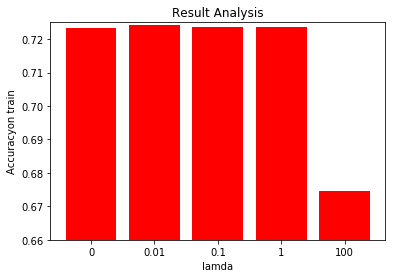

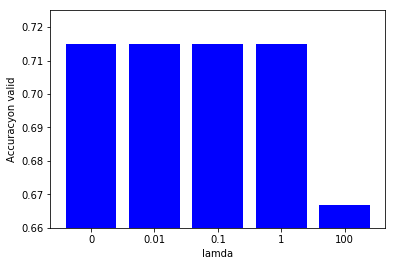

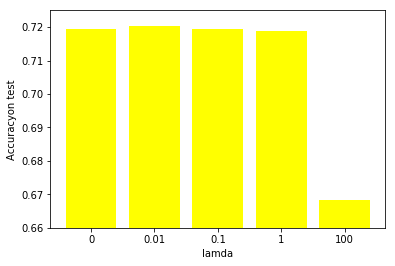

In [40]:
new_acc = []
for i in range(3):
    unit_acc = []
    for elem in acc:
        unit_acc.append(elem[i])
    new_acc.append(unit_acc)
print (new_acc)
lam_list = ['0', '0.01','0.1', '1', '100']
color_list = ['red','blue','yellow','green','black']
dataset = ['train','valid','test']
plt.title('Result Analysis')
for i in range(3):
    plt.bar(lam_list,new_acc[i],color=color_list[i])
    plt.xlabel('lamda')
    plt.ylabel('Accuracy'+"on "+dataset[i])
    plt.ylim(0.66,0.725)
    plt.show()